<a href="https://colab.research.google.com/github/theofarouk/IMDA/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of a variational auto encoder step by step

Hazem Wannous, GenAI summer school, 2025

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
It is difficult to generate new objects from the distribution of hidden variables in conventional autoencoders. In order to generate new objects, the latent variables space must be predictable. Variational autoencoders are autoencoders that learn how to map objects into a given hidden space and, accordingly, sample from it. Therefore, variational autoencoders are also referred to the family of generative models.
</div>

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Libraries</b>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout

In [2]:
# # Load and prepare the MNIST dataset

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Noiser, Dropout & BatchNorm</b>
</div>

In [3]:
def dropout_and_batchnorm(x):
    return Dropout(0.3)(BatchNormalization()(x))

def noiser(args):
    global mean, log_var
    mean, log_var = args
    N = tf.random.normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return tf.exp(log_var / 2) * N + mean

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Module: Encoder</b>
</div>

In [4]:
hidden_dim = 2
batch_size = 60

In [5]:
input_image = Input(batch_shape=(batch_size, 28, 28, 1))
x = Flatten()(input_image)
x = Dense(256, activation="relu")(x)
x = dropout_and_batchnorm(x)
x = Dense(128, activation="relu")(x)
x = dropout_and_batchnorm(x)

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Module: Latent space</b>
</div>

In [6]:
mean = Dense(hidden_dim)(x)
log_var = Dense(hidden_dim)(x)
#h = Lambda(noiser, output_shape=(hidden_dim), name="latent_space")([mean, log_var])
h = Lambda(noiser, output_shape=(hidden_dim, ), name="latent_space")([mean, log_var])

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Module: Decoder</b>
</div>

In [7]:
input_decoder = Input(shape=(hidden_dim,))
d = Dense(128, activation="relu")(input_decoder)
d = dropout_and_batchnorm(d)
d = Dense(256, activation="relu")(d)
d = dropout_and_batchnorm(d)
d = Dense(28*28, activation="sigmoid")(d)
decoded = Reshape((28, 28, 1))(d)

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Loss</b>
</div>

In [8]:
def vae_loss(x, y):
    x = tf.reshape(x, shape=(batch_size, 28*28))
    y = tf.reshape(y, shape=(batch_size, 28*28))
    loss = tf.reduce_sum(tf.square(x - y), axis=-1)
    kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=-1)
    return loss + kl_loss

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Model</b>
</div>

In [9]:
encoder = keras.Model(input_image, h, name="encoder")
decoder = keras.Model(input_decoder, decoded, name="decoder")
vae = keras.Model(input_image, decoder(encoder(input_image)), name="vae")
vae.compile(optimizer="adam", loss=vae_loss)
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (60, 28, 28, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (60, 2)                │       235,908 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (60, 28, 28, 1)        │       236,432 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 472,340 (1.80 MB)

 Trainable params: 470,804 (1.80 MB)

 Non-trainable params: 1,536 (6.00 KB)

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Fiting</b>
</div>

In [10]:
epochs = 25

vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True
       )

Epoch 1/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 93.7800
Epoch 2/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 45.0713
Epoch 3/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 43.6951
Epoch 4/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 43.0870
Epoch 5/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 42.7622
Epoch 6/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 42.5072
Epoch 7/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 42.1807
Epoch 8/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 41.8267
Epoch 9/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 41.5430
Epoch 10/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 41.4832
Epoch 11/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 41.5002
Epoch 12/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 41.1691
Epoch 13/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 41.0964
Epoch 14/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - l

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Latent space</b>
</div>

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


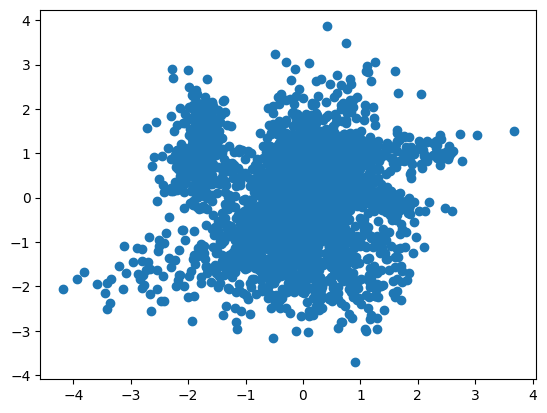

In [11]:
h = encoder.predict(x_test[:3000], batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])
plt.show()

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Results</b>
</div>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


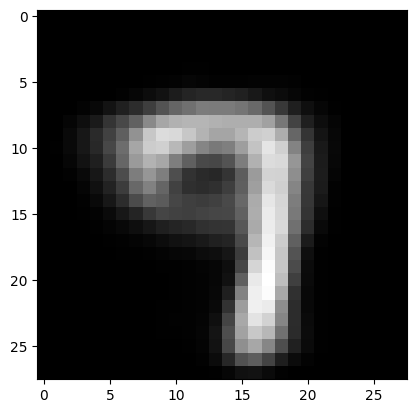

In [12]:
image = decoder.predict(np.expand_dims([0.94, 2], axis=0))
plt.imshow(image.squeeze(), cmap="gray")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

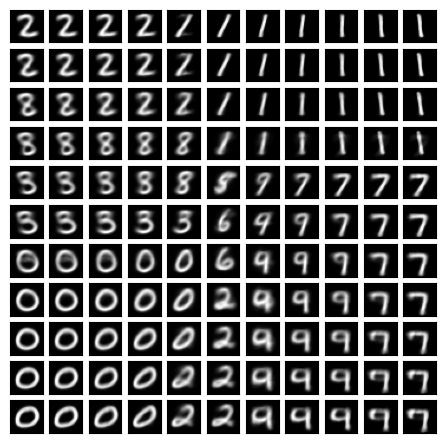

In [13]:
n =  5
size = 2*n+1

num = 1
plt.figure(figsize=(size/2, size/2))
for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(size, size, num)
        num += 1
        image = decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0))
        plt.imshow(image.squeeze(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

**Exercice**: Extend this encoder to Convolutional VAE!


In [14]:
#x_train = x_train.reshape((-1, 28, 28, 1)).astype("float32")
#x_test  = x_test.reshape((-1, 28, 28, 1)).astype("float32")

In [15]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, ReLU
from tensorflow.keras.losses import binary_crossentropy
import numpy as np

latent_dim = 2          # pour visualiser le latent space
input_shape = (28, 28, 1)

# ----- Sampling layer (reparameterization trick) -----
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ----- Encoder CNN -----
encoder_inputs = Input(shape=input_shape)

x = Conv2D(32, kernel_size=3, strides=2, padding="same")(encoder_inputs)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# On garde la forme pour le décoder plus tard
shape_before_flatten = tf.keras.backend.int_shape(x)[1:]  # (h, w, c)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3136)      │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │    401,536 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 421,252 (1.61 MB)

 Trainable params: 421,060 (1.61 MB)

 Non-trainable params: 192 (768.00 B)

In [16]:
# ----- Decoder CNN -----
latent_inputs = Input(shape=(latent_dim,))

# On remonte à la taille du feature map avant flatten
units = np.prod(shape_before_flatten)  # h * w * c
x = Dense(units, activation="relu")(latent_inputs)
x = Reshape(shape_before_flatten)(x)

x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)

decoder_outputs = Conv2DTranspose(1, kernel_size=3, padding="same", activation="sigmoid")(x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,473 (255.75 KB)

 Trainable params: 65,281 (255.00 KB)

 Non-trainable params: 192 (768.00 B)

In [19]:
class ConvVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        # ----- Reconstruction loss -----
        # On somme sur (H, W, C), puis on moyenne sur le batch
        recon_loss = tf.reduce_sum(
            binary_crossentropy(inputs, reconstruction),
            axis=(1, 2) # Changed from (1, 2, 3) to (1, 2)
        )
        recon_loss = tf.reduce_mean(recon_loss)

        # ----- KL divergence -----
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        total_loss = recon_loss + kl_loss
        self.add_loss(total_loss)

        return reconstruction

vae = ConvVAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [20]:
batch_size = 128
epochs = 20  # par exemple

history = vae.fit(
    x_train,
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test)
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 136s 281ms/step - loss: 256.0960 - val_loss: 174.9007
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 276ms/step - loss: 170.1547 - val_loss: 160.8956
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 131s 280ms/step - loss: 159.3527 - val_loss: 155.8359
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 277ms/step - loss: 155.4564 - val_loss: 153.1479
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 126s 269ms/step - loss: 152.9629 - val_loss: 151.5770
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 131s 280ms/step - loss: 151.1541 - val_loss: 150.5170
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 126s 269ms/step - loss: 149.8368 - val_loss: 149.5670
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 273ms/step - loss: 149.4552 - val_loss: 148.8643
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 267ms/step - loss: 148.2529 - val_loss: 148.2492
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 132s 281ms/step - loss: 147.0936 - val_loss: 148.1368
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 136s 269ms/step - 

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


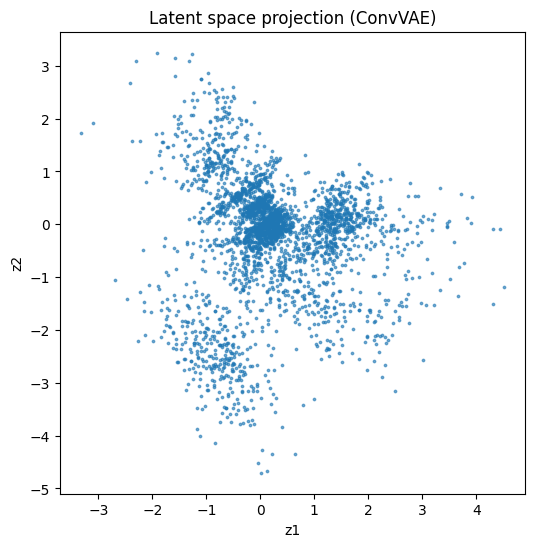

In [21]:
# Encode 3000 images du testset
z_mean, z_log_var, z = encoder.predict(x_test[:3000], batch_size=128)

plt.figure(figsize=(6, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], s=3, alpha=0.6)
plt.title("Latent space projection (ConvVAE)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


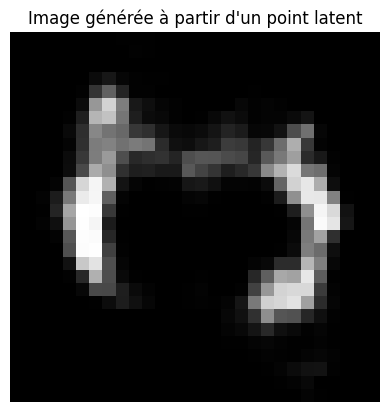

In [27]:
# Choisir un point dans le latent
sample = np.array([[2.0, 3.0]])

# Passer dans le décodeur
generated = decoder.predict(sample)

plt.imshow(generated.squeeze(), cmap="gray")
plt.title("Image générée à partir d'un point latent")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

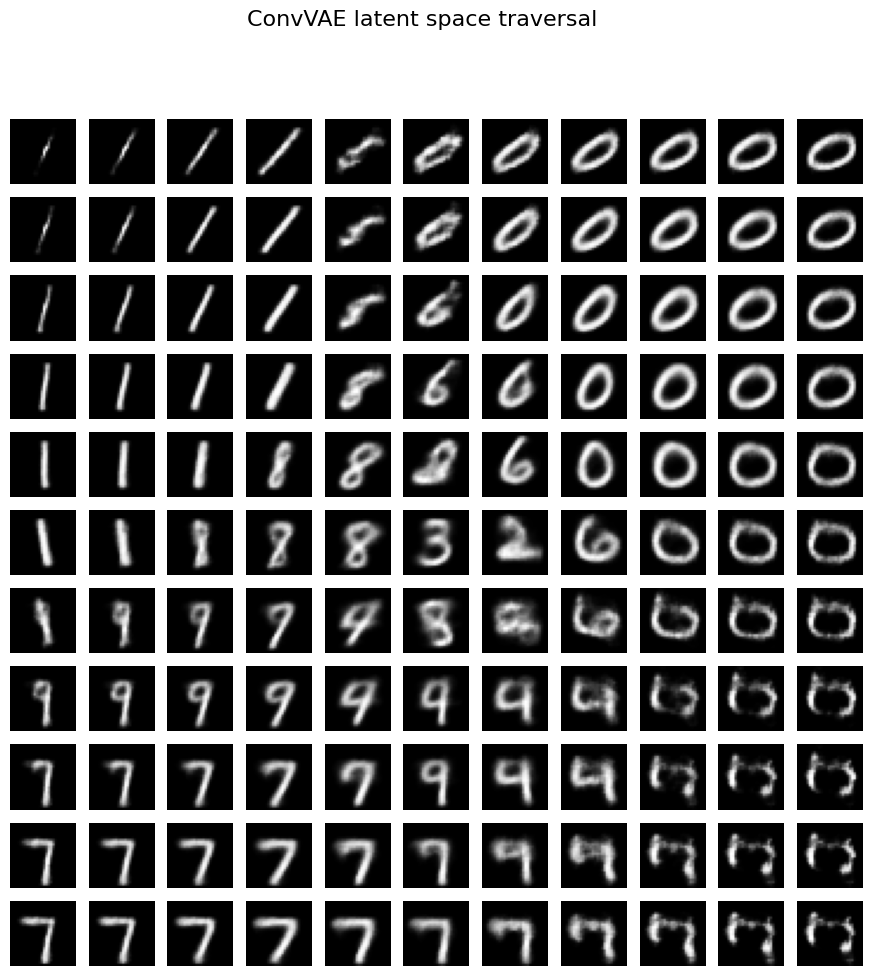

In [28]:
n = 5
size = 2*n + 1

plt.figure(figsize=(size, size))
num = 1

for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(size, size, num)
        num += 1

        latent = np.array([[3*i/n, 3*j/n]])
        img = decoder.predict(latent)

        plt.imshow(img.squeeze(), cmap="gray")
        plt.axis("off")

plt.suptitle("ConvVAE latent space traversal", fontsize=16)
plt.show()
